`python3 -m pip install -U pandas wavescapes`

In [13]:
import os, re
import pandas as pd
import numpy as np
from wavescapes import Wavescape, apply_dft_to_pitch_class_matrix, complex_utm_to_ws_utm

def get_standard_filename(fname):
    fname_filter = r"(l\d{3}(?:-\d{2})?(?:_[a-z]+){1,2})"
    m = re.search(fname_filter, fname)
    if m is None:
        return
    return m.groups(0)[0]

def parse_interval_index(df, name='iv'):
    iv_regex = r"\[([0-9]*\.[0-9]+), ([0-9]*\.[0-9]+)\)"
    df = df.copy()
    values = df.index.str.extract(iv_regex).astype(float)
    iix = pd.IntervalIndex.from_arrays(values[0], values[1], closed='left', name=name)
    df.index = iix
    return df


Loading metadata

In [14]:
metadata = pd.read_csv('metadata.tsv', sep='\t', index_col=1)
fname2year = (metadata.composed_end + metadata.composed_start) / 2
print(f"Metadata for {fname2year.shape[0]} files.")
fname2year

Metadata for 58 files.


fnames
MIDIl087-03_images_quelques        NaN
l000_etude                      1915.0
l000_soirs                      1917.0
l009_danse                      1880.0
l066-01_arabesques-premiere     1888.0
l067_mazurka                    1890.0
l068_reverie                    1890.0
l069_tarentelle                 1890.0
l070_ballade                    1890.0
l071_valse                      1890.0
l082_nocturne                   1892.0
l087-01_images_lent             1894.0
l095-01_pour_prelude            1901.0
l095-02_pour_sarabande          1894.0
l095-03_pour_toccata            1901.0
l100-01_estampes_pagode         1903.0
l100-02_estampes_soiree         1903.0
l100-03_estampes_jardins        1903.0
l106_isle                       1904.0
l110-01_images_reflets          1904.0
l110-02_images_hommage          1904.0
l110-03_images_mouvement        1905.0
l111-02_images_lune             1907.0
l113-01_childrens_doctor        1907.0
l113-02_childrens_jimbos        1907.0
l113-03_childrens_

Loading TSV files each containing the Pitch Class Vectors (PCVs) for one piece. The resulting DataFrames have indices of type `pd.IntervalIndex`. 

In [15]:
pcv_dir = './pcvs'
_, _, pcv_files = next(os.walk(pcv_dir))
pcv_dfs = {get_standard_filename(fname): pd.read_csv(os.path.join(pcv_dir, fname), sep='\t', index_col=0) for fname in sorted(pcv_files)}
pcv_dfs = {k: parse_interval_index(v).fillna(0.0) for k, v in pcv_dfs.items()}
pcv_dfs['l000_etude'].head(10)

,0,1,2,3,4,5,6,7,8,9,10,11
iv,,,,,,,,,,,,
"[0.0, 1.0)",0.167,0.0,0.0,0.334,0.0,0.000,0.0,0.0,1.334,0.0,0.167,0.0
"[1.0, 2.0)",0.167,0.0,0.0,0.334,0.0,0.334,0.0,0.0,1.167,0.0,0.000,0.0
"[2.0, 3.0)",0.167,0.0,0.0,0.334,0.0,0.334,0.0,0.0,0.167,0.0,0.000,0.0
"[3.0, 4.0)",0.167,0.0,0.0,0.334,0.0,0.334,0.0,0.0,0.167,0.0,0.000,0.0
"[4.0, 5.0)",0.167,0.0,0.0,0.334,0.0,0.334,0.0,0.0,1.167,0.0,0.000,0.0
"[5.0, 6.0)",0.167,0.0,0.0,0.334,0.0,0.334,0.0,0.0,1.167,0.0,0.000,0.0
"[6.0, 7.0)",0.167,0.0,0.0,0.334,0.0,0.334,0.0,0.0,1.167,0.0,0.000,0.0
"[7.0, 8.0)",0.143,0.0,0.0,0.286,0.0,0.429,0.0,0.0,1.143,0.0,0.000,0.0
"[8.0, 9.0)",0.167,0.0,0.0,0.334,0.0,0.000,0.0,0.0,1.334,0.0,0.167,0.0


Apply Discrete Fourier Transform (DFT) to each and store the results in `dfts`:

In [16]:
dfts = {k: apply_dft_to_pitch_class_matrix(v.to_numpy()) for k, v in pcv_dfs.items()}
{k: v.shape for k, v in dfts.items()}

{'l000_etude': (284, 284, 7),
 'l087-03_images_quelques': (679, 679, 7),
 'l000_soirs': (89, 89, 7),
 'l009_danse': (182, 182, 7),
 'l066-01_arabesques': (423, 423, 7),
 'l067_mazurka': (411, 411, 7),
 'l068_reverie': (403, 403, 7),
 'l069_tarentelle': (995, 995, 7),
 'l070_ballade': (420, 420, 7),
 'l071_valse': (451, 451, 7),
 'l082_nocturne': (352, 352, 7),
 'l087-01_images_lent': (172, 172, 7),
 'l095-01_pour_prelude': (535, 535, 7),
 'l095-02_pour_sarabande': (216, 216, 7),
 'l095-03_pour_toccata': (530, 530, 7),
 'l100-01_estampes_pagode': (388, 388, 6),
 'l100-02_estampes_soiree': (279, 279, 7),
 'l100-03_estampes_jardins': (628, 628, 7),
 'l106_isle': (458, 458, 7),
 'l110-01_images_reflets': (190, 190, 7),
 'l110-02_images_hommage': (445, 445, 7),
 'l110-03_images_mouvement': (353, 353, 7),
 'l111-02_images_lune': (227, 227, 7),
 'l113-01_childrens_doctor': (298, 298, 7),
 'l113-02_childrens_jimbos': (320, 320, 7),
 'l113-03_childrens_serenade': (354, 354, 7),
 'l113-05_childr

Minimal example for drawing a wavescape

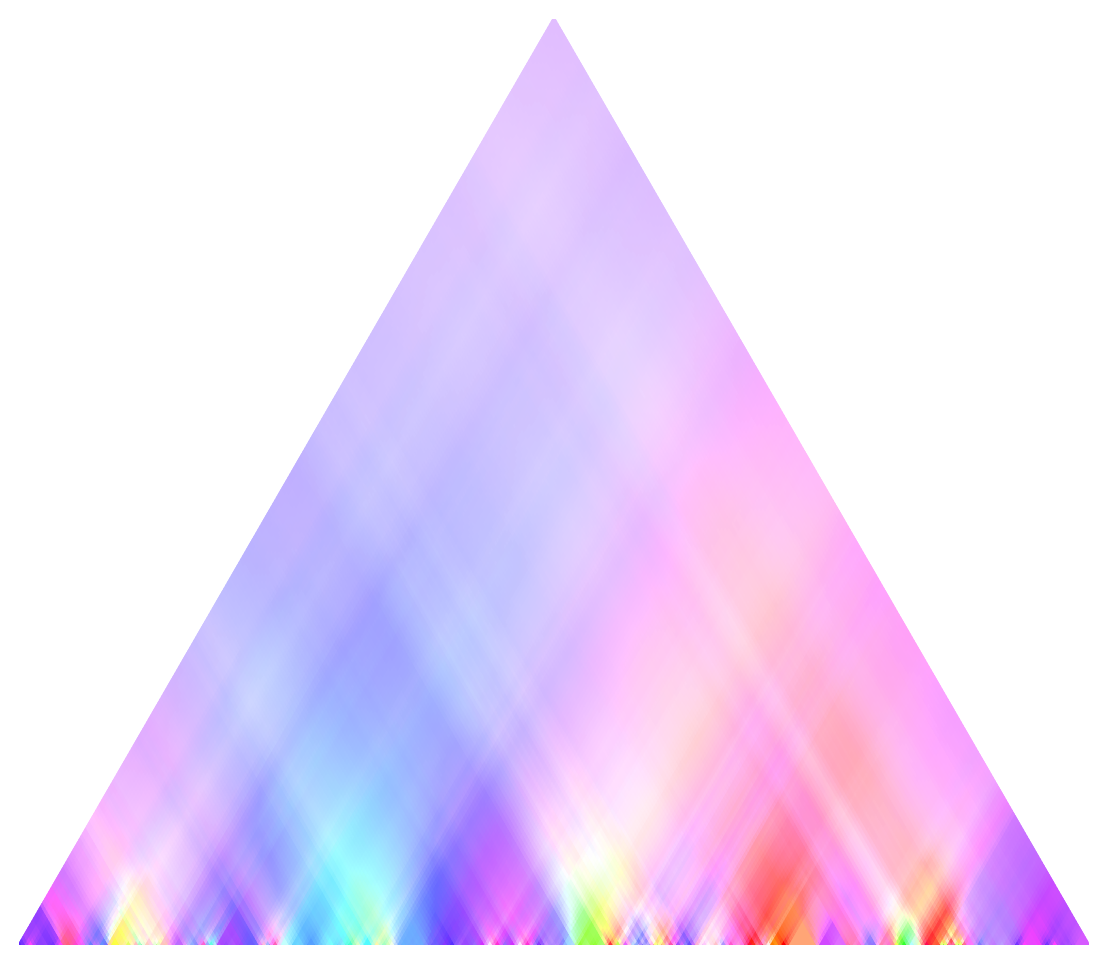

In [17]:
piece = 'l000_etude'
coeff = 5
dft = dfts[piece]
N = dft.shape[0]
width = 500 if N <= 250 else 2 * N
ws = Wavescape(complex_utm_to_ws_utm(dft, coeff=coeff), width=width)
ws.draw()

In [25]:
def comp2str(c, dec=2):
    magn = np.round(abs(c), dec)
    ang = -round(np.angle(c, True)) % 360
    return f"{magn}+{ang}°"

format_comp = np.vectorize(comp2str)

def get_coeff(dft, x, y, k=None, angles=True, invert_x=True):
    xs, ys, _ = dft.shape
    assert 0 <= x < xs, f"0 <= x < {xs}; received x = {x}" 
    assert 0 <= y < ys, f"0 <= y < {ys}; received y = {y}"
    if invert_x:
        x = y - x
    if k is None:
        result = dft[x][y]
    else:
        assert 0 <= k < 7, "0 <= k < 7"
        result = dft[x][y][k]
    if angles:
        return format_comp(result)
    return result

get_coeff(dft, 4, 4, 5)

array('1.52+95°', dtype='<U8')